In [1]:
import pandas as pd
import numpy as np
%config inlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%run DLMO.ipynb
# plt.rcParams['font.family'] = 'Helvetica'


In [2]:

file_path = "/data/work/shared/safe_data/sleep_skew/skew_project_start_oct_2022/"

'''Getting the sleeping info of the chosen user from another file'''
sleep_sample = pd.read_csv(file_path+"sleep_skew_data_w_demographics.csv")
sleep_sample['sleep_duration_round'] = np.round(sleep_sample['sleep_duration']/3600,2)
sleep_sample['sleep_start'] = pd.to_datetime(sleep_sample['day_label'],unit='d')
sleep_sample['sleep_start_shift'] = np.where(sleep_sample['start_time_num_round'] >= 12,
                                            sleep_sample['sleep_start'],
                                             sleep_sample['sleep_start']-pd.to_timedelta(1,unit='d')
                                            )
sleep_sample['day_of_week'] = sleep_sample['sleep_start_shift'].dt.day_name()
sleep_sample['weekend'] = np.where(sleep_sample['day_of_week'].isin(['Friday','Saturday']),1,0)

sleep_sample['start_time_num_round_25'] = ((sleep_sample['start_time_num_round']%1)*100/60)+sleep_sample['start_time_num_round'].astype(int)
sleep_sample['end_time_num_round_25'] = ((sleep_sample['end_time_num_round']%1)*100/60)+sleep_sample['end_time_num_round'].astype(int)

'''EXCEPTION HANDLING FOR 24.00 : SHOULD SHOW AS 00.00'''

sleep_sample['start_time_num_round_25'] = round(sleep_sample['start_time_num_round_25']*4)/4
sleep_sample['end_time_num_round_25'] = round(sleep_sample['end_time_num_round_25']*4)/4

sleep_sample['start_time_num_round_25'] = np.where(sleep_sample['start_time_num_round_25']==24,0,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(sleep_sample['end_time_num_round_25']==24,0,sleep_sample['end_time_num_round_25'])

''' EXCEPTION HANDLING FOR SLEEP ONSET BETWEEN 23.45 AND 23.59 : SHOW AS 23.75 '''
sleep_sample['start_time_num_round_25'] = np.where(((sleep_sample['start_time_num_round'] >= 23.45) &
                                                   (sleep_sample['start_time_num_round'] < 24.0)), 23.75,sleep_sample['start_time_num_round_25'])
sleep_sample['end_time_num_round_25'] = np.where(((sleep_sample['end_time_num_round'] >= 23.45) &
                                                  (sleep_sample['end_time_num_round'] < 24.0)), 23.75,sleep_sample['end_time_num_round_25']) 

''' 
Defining Naps and shift sleep
If someone sleeps between 11am and 3pm
    - Less than 3 hours : Nap
    - More than 3 hours : Shift worker sleep
'''
sleep_sample['nap'] = np.where(
    ((sleep_sample['sleep_duration_round']<3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)
sleep_sample['shift_sleep'] = np.where(
    ((sleep_sample['sleep_duration_round']>=3) & 
     (sleep_sample['start_time_num_round'] < 15) & 
     (sleep_sample['start_time_num_round'] > 11)),1,0)


'''Deleting shift sleeps'''
sleep_sample = sleep_sample[(sleep_sample['shift_sleep'] ==0) &
                           (sleep_sample['nap'] ==0)]

sleep_sample.drop(columns={'gender','age_group','country','weekday','day_label','day_label_shift'},inplace=True)
sleep_sample.sort_values(by=['user_id','sleep_start_shift','sleep_start','start_time_num_round'],inplace=True)




In [3]:
sleep_sample.head()

,user_id,day_of_week,weekend,start_time_num_round,end_time_num_round,sleep_duration,sleep_duration_round,sleep_start,sleep_start_shift,start_time_num_round_25,end_time_num_round_25,nap,shift_sleep
30176662,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Saturday,1,23.40,7.50,28860,8.02,2016-04-02,2016-04-02,23.75,7.75,0,0
30176686,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Sunday,0,0.05,7.10,24840,6.90,2016-04-04,2016-04-03,0.00,7.25,0,0
30176649,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Monday,0,21.00,2.35,19980,5.55,2016-04-04,2016-04-04,21.00,2.50,0,0
30176716,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Tuesday,0,22.05,6.40,30240,8.40,2016-04-05,2016-04-05,22.00,6.75,0,0
30176655,000018a5bf49253cc9bc32fb7bc687d24234ffaf1779bd...,Wednesday,0,22.20,7.00,28740,7.98,2016-04-06,2016-04-06,22.25,7.00,0,0


In [4]:
_skew = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').skew()
_skew = _skew.reset_index()
_skew.rename(columns={'sleep_duration_round':'sleep_duration_skew'},inplace=True)

_avg = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').mean()
_avg = _avg.reset_index()
_avg.rename(columns={'sleep_duration_round':'sleep_duration_avg'},inplace=True)

_med = sleep_sample[['user_id','sleep_duration_round']].groupby('user_id').median()
_med = _med.reset_index()
_med.rename(columns = {'sleep_duration_round':'sleep_duration_median'},inplace=True)
_skew = _skew.merge(_med,how='left', left_on='user_id',right_on='user_id')
_skew['sleep_dur_median_bucket']= np.round(_skew['sleep_duration_median']*2)/2
_skew.sort_values(by='sleep_duration_skew',ascending=False, inplace=True)

_skew = _skew.merge(_avg, how='left',left_on = 'user_id',right_on='user_id')
_skew

,user_id,sleep_duration_skew,sleep_duration_median,sleep_dur_median_bucket,sleep_duration_avg
0,95be4aeeb0cea3948bb94641092be92c159c459bc3d634...,5.969185,3.000,3.0,3.042609
1,737f2d41689a4e71291ef2b4d6845b1862d4b1e49a10d7...,5.373081,2.430,2.5,2.441644
2,10efc6828f07e83102d01b86e507bcc4b36d81c782afb5...,5.262231,2.370,2.5,2.691778
3,4696b1e4660c4a01233627f3af59c4cb8e59347ae36ca6...,5.082906,2.820,3.0,3.015258
4,ecfe7116d073ee097dd72189c9b3ee03c2ab5869b46f28...,4.648011,2.530,2.5,2.857347
...,...,...,...,...,...
112923,8078c2e5d72169c97c08b607d5d59c571f4d801f46fdf4...,-3.519943,8.480,8.5,8.375570
112924,b213f829e63214a7d4b3811e9662d1ca01b0ae7de42de6...,-3.547488,6.875,7.0,6.741852
112925,d00ba82fef5319c328c8a205dc025f3efaedb105427a6c...,-3.560369,10.460,10.5,10.326959
112926,537cd7804b9d03c29d36292877a56fb507dc7c354e624f...,-3.908927,8.450,8.5,8.362400


In [5]:
sleep_sample = sleep_sample.merge(_skew[['user_id','sleep_duration_median','sleep_duration_skew']],
                                 how='left',left_on='user_id',right_on='user_id')
sleep_sample['catchup_flag'] = np.where(sleep_sample['sleep_duration_round']>sleep_sample['sleep_duration_median']+1,
                                        1,0)

In [6]:


print(" < -2.0: ",len(_skew[_skew['sleep_duration_skew'] < -2.0]))
print("-2.0 <= x < -1.5: ",len(_skew[(_skew['sleep_duration_skew'] >= -2.0) & (_skew['sleep_duration_skew'] < -1.5)]))
print("-1.5<= x< -1.0: ",len(_skew[(_skew['sleep_duration_skew'] >= -1.5) & (_skew['sleep_duration_skew'] < -1.0)]))
print("-1.0<x< -0.5: ",len(_skew[(_skew['sleep_duration_skew'] >= -1.0) & (_skew['sleep_duration_skew'] < -0.5)]))
print("-0.5<x< 0: ",len(_skew[(_skew['sleep_duration_skew'] >= -0.5) & (_skew['sleep_duration_skew'] < 0)]))
print("0 <x< 0.5: ",len(_skew[(_skew['sleep_duration_skew'] >= 0) & (_skew['sleep_duration_skew'] < 0.5)]))
print("0.5 <x< 1.0: ",len(_skew[(_skew['sleep_duration_skew'] >= 0.5) & (_skew['sleep_duration_skew'] < 1.0)]))
print("1.0 <x< 1.5: ",len(_skew[(_skew['sleep_duration_skew'] >= 1.0) & (_skew['sleep_duration_skew'] < 1.5)]))
print("1.5 <x< 2.0: ",len(_skew[(_skew['sleep_duration_skew'] >= 1.5) & (_skew['sleep_duration_skew'] < 2.0)]))
print(" > 2.0: ",len(_skew[_skew['sleep_duration_skew'] > 2]))

 < -2.0:  399
-2.0 <= x < -1.5:  1535
-1.5<= x< -1.0:  6730
-1.0<x< -0.5:  20561
-0.5<x< 0:  36073
0 <x< 0.5:  31069
0.5 <x< 1.0:  12495
1.0 <x< 1.5:  3107
1.5 <x< 2.0:  647
 > 2.0:  312


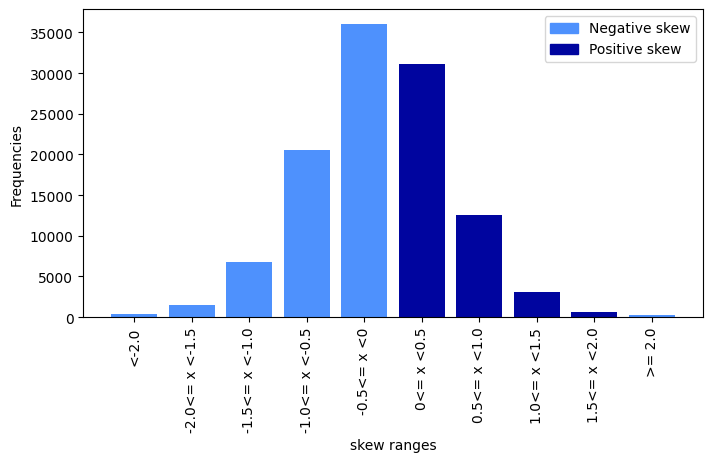

In [7]:
color_for_bars = ["#4e91fd", "#4e91fd", "#4e91fd","#4e91fd", "#4e91fd","#00059f","#00059f","#00059f","#00059f"]
plt.figure(figsize=(8,4))
get_x = ['<-2.0','-2.0<= x <-1.5','-1.5<= x <-1.0','-1.0<= x <-0.5', '-0.5<= x <0', '0<= x <0.5','0.5<= x <1.0',
        '1.0<= x <1.5', '1.5<= x <2.0', '>= 2.0']
get_y = [399,1535,6730,20561,36073,31069,12495,3107,647,312]
plt.bar(get_x, get_y,color = color_for_bars)
plt.xticks(rotation = 90, ha = 'center')
plt.xlabel("skew ranges")
plt.ylabel("Frequencies")
import matplotlib.patches as mpatches
neg_patch = mpatches.Patch(color = '#4e91fd',label = "Negative skew")
pos_patch = mpatches.Patch(color = '#00059f',label = "Positive skew")
plt.legend(handles = [neg_patch, pos_patch],loc='upper right')
plt.savefig("/file/out/antar/skew_by_user_count",dpi=400)
plt.show()

In [41]:
sleep_count_catchup = sleep_sample[['user_id','catchup_flag']].groupby('user_id').agg({'count','sum'}).reset_index()
sleep_count_catchup.columns = ['user_id','count','sum']
sleep_count_catchup['perc_catchup_float'] = sleep_count_catchup['sum']/sleep_count_catchup['count']
sleep_count_catchup['perc_catchup'] = np.round(sleep_count_catchup['sum']/sleep_count_catchup['count'],1)
sleep_count_catchup = sleep_count_catchup.merge(_skew[['user_id','sleep_duration_skew']],how='left',
                                               left_on='user_id',right_on='user_id')
sleep_count_catchup['sleep_skew_bucket'] = np.round(sleep_count_catchup['sleep_duration_skew'],1)
sleep_count_catchup = sleep_count_catchup.sort_values(by='perc_catchup')
sleep_count_catchup['perc_catchup'] = sleep_count_catchup['perc_catchup'].astype(float).map('{:.2%}'.format)
sleep_count_catchup

,user_id,count,sum,perc_catchup_float,perc_catchup,sleep_duration_skew,sleep_skew_bucket
84868,c01f2863d9f8350254f53349cee9808685d65ed084ffc6...,90,0,0.000000,0.00%,-1.834968,-1.8
79406,b3c32b65d5b6eab47d069418adb82ef480d2b158ba1bb2...,61,0,0.000000,0.00%,-1.791156,-1.8
46394,69519c864961fb11eef53cbf096ae32299ab10d3def0bf...,92,4,0.043478,0.00%,-2.059465,-2.1
43117,61c1a7e2d39f391ccc84ac2b2409589afc8cdfbb817203...,149,1,0.006711,0.00%,-2.443059,-2.4
61077,8a10ccd533b01cb2520205fb1442e1305a80285fb64de5...,806,11,0.013648,0.00%,-2.940789,-2.9
...,...,...,...,...,...,...,...
70270,9f1d3e27e3deecf243520b052070d8fbe6f76f3c935c65...,178,82,0.460674,50.00%,0.130479,0.1
101202,e5946710cdf1cda76e11404e8591ae257a471a69bddcda...,38,18,0.473684,50.00%,0.184133,0.2
59620,86c39f5101c73fbad1e2503daece68a8d02fde7495ad62...,204,93,0.455882,50.00%,0.235694,0.2
98031,de104ac758e4e5311eab4337028f2cad9aee404cebb3ae...,74,34,0.459459,50.00%,0.091897,0.1


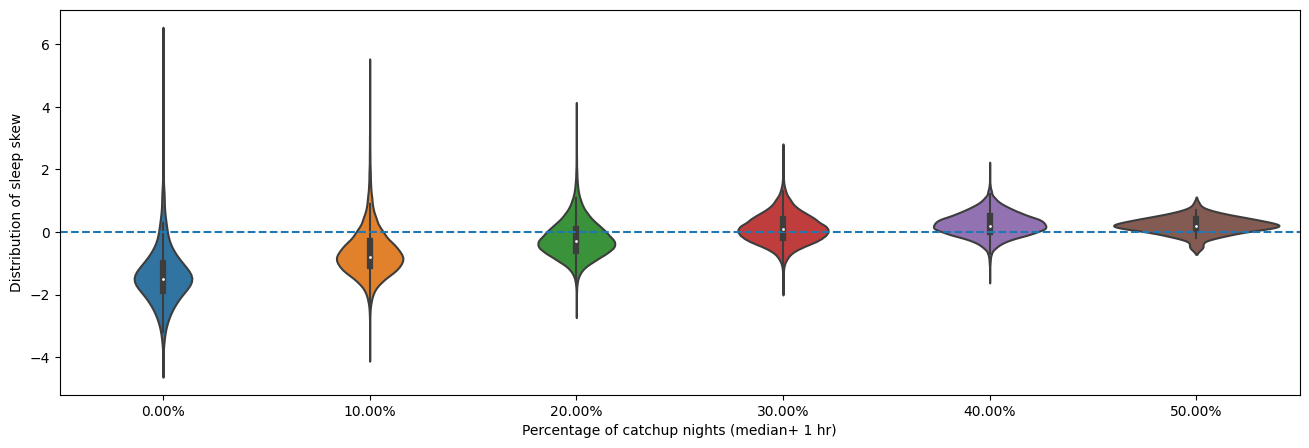

In [40]:
import seaborn as sns
plt.figure(figsize = (16,5))
sns.color_palette('colorblind')
sns.violinplot(x = 'perc_catchup',
            y = 'sleep_skew_bucket',
            data = sleep_count_catchup)
plt.xlabel("Percentage of catchup nights (median+ 1 hr)")
plt.ylabel("Distribution of sleep skew")
plt.axhline(y=0,linestyle='dashed')

plt.show()

In [45]:
from sklearn.linear_model import LinearRegression
X = np.array(sleep_count_catchup['perc_catchup_float']).reshape(-1,1)
y=np.array(sleep_count_catchup['sleep_duration_skew']).reshape(-1,1)
reg = LinearRegression().fit(X,y)
reg.score(X,y)

0.20842745160074205

In [22]:
np.corrcoef(sleep_count_catchup['perc_catchup'], sleep_count_catchup['sleep_skew_bucket'])

array([[1.        , 0.42517231],
       [0.42517231, 1.        ]])

In [17]:
countofsleeps = pd.DataFrame(sleep_sample[(sleep_sample['nap'] == 0) &
                            (sleep_sample['shift_sleep'] == 0)]['user_id'].value_counts()).reset_index()
countofsleeps.columns=['user_id','count']
countofsleeps = countofsleeps[countofsleeps['count']>100]

In [18]:
countofsleeps

,user_id,count
0,31a01df1a3581b7d58a7f80999597b7f5305fb4c7a7531...,1417
1,e77e8e5ebf45c0daad8b13796f08184df03fb7f8473a20...,1411
2,99ee31a2abac457da7360dba05f9d47040493065964dc6...,1409
3,c85c8be875e5e8c74e327914622ebe7e0262cb591f806b...,1407
4,e332e723745bcfadc59d7ef26b11f4f7528b261fbfc98b...,1405
...,...,...
81905,b535dbde172ac572c04b0c0818f6cd2f9c6de36b3fc0f7...,101
81906,a8814ad053054dd3fbdf107e0407ab8d40b679aec4363d...,101
81907,e5ca99e16921022e8b9ee059dd5f1a54fd971c2010c4f3...,101
81908,cce2076b4a2e336ad47d9901438b84f30655ac3678c680...,101
